# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) and a case study of Liquid-Liquid equilibria of Ethyl acetate (1) + water (2) + ethanol (3)

Having previously discussed *Excess thermodynamic properties*, excess energy models, the NRTL model specifically, and VLE, we now proceed to study LLE.

# Requirements

# The NumPy package
for array structures and operations

In [1]:
import numpy as np

## The pyplot interface from the matplotlib package

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

# physical constants in the international system of units

In [3]:
from scipy.constants import R
print(R)

8.3144598


# some special purpose functions that will help us in our analyzes

In [4]:
def stdv(v): #will standardize an array, transforming all values to between 0 and 1
    w=(v-np.min(v))/(np.max(v)-np.min(v))
    return w

# The NRTL model
as presented in previous lecture
* reproduced below in minimalist numpy/numba format

In [5]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

# Fitted parameters
Parameters from Renon and Prausnitz, 1969.

In [6]:
# Ethyl acetate (1) + water (2) + ethanol (3)

alpha12 = 0.4

alpha23 = 0.3

alpha13 = 0.3

# 6 binary Aij parameters
Dg12 = 1335 * 4.184 #J/K
Dg21 = 2510 * 4.184 #J/K

Dg23 = 976 * 4.184 #J/K
Dg32 = 88 * 4.184 #J/K

Dg13 = 301 * 4.184 #J/K
Dg31 = 322 * 4.184 #J/K

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure compatible with the current imlementation of the model

In [7]:
#assemble matrix with regressed parameters Dg_i,j, according to the model all diagonal terms are zero
Dg = np.array([[0, Dg12, Dg13],
             [Dg21, 0, Dg23],
             [Dg31, Dg32, 0]])


#assemble symmetric matrix alpha
alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A= Dg/R

* This notebook shall contain calculations at the temperature of 70 deg C

In [8]:
T = 273+70 #K

# Liq-Liq Equilibria Flash
Now we start discussing the Liq-Liq equilibria flash calculation

it works as follows:

The degrees of Freedom for a flash calculation are temperature - T, pressure - P and global composition - z

<img src=supportFiles/algorithms.png width=500>|

**Equilibriuma criteria**

$$\mu_{i}^{\rm {L1}}=\mu_{i}^{\rm {L2}}, \forall i$$

**Devised algorithm after analytical simplification of repeated contributions:**

$$x_{i}^{\rm {L1}} \gamma_{i}^{\rm {L1}}= x_{i}^{\rm {L2}} \gamma_{i}^{\rm {L2}}, \forall i$$

# algorithm
based on Rachford and Rice (1952) approach to LV equilibrium


Ref: Rachford HH, Rice JD, Petroleum Trans AIME 1952;195:327-328

In [9]:
def ELLflash_explicit(Z,beta0,K0,MODEL,qolog):
    
    #copy intial guesses to local variables
    beta=beta0.copy()
    K=K0.copy()

    converged = 0 # flag indicating not converged yet
    
    if qolog:
        itlogi=0
        itlogv=np.ndarray(2,dtype=object)
        itlogv[0]=np.zeros(100*100)
        itlogv[1]=np.zeros([100*100,3])
    
    #initialize local arrays
    a = np.zeros(3)
    XI = np.zeros(3)
    XII = np.zeros(3)
    
    looped2=0
    looped3=0
    
    #managing loop for fixed point point algorithm
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        prevK = K.copy()
        
        #print(np.may_share_memory(K,prevK))
        
        #Solve RachfordRice equation with a newton raphson loop
        looping3 = 0
        while ( (looping3 == 0) # means do at least once
               or ((ResBeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()

            for i in range(3):
                a[i] = ( (K[i]-1) / (1+beta*(K[i]-1)) )            
                
            R=0 #residue funtion (F)
            for j in range(3):
                R+=Z[j]*a[j]

            J=0 #jacobian (Fprime)
            for j in range(3):
                J-=Z[j]*a[j]*a[j]
                            
            beta -= R/J #NR step            
            
            if beta[0,0]<0:
                beta[0,0]=0
                
            if 1<beta[0,0]:
                beta[0,0]=1
            
            ResBeta = abs(beta[0,0]-prevbeta[0,0])
            
            looping3 += 1        
            
            if qolog:
                #print(looping3,beta0,prevbeta[0,0],beta[0,0],ResBeta)
                itlogv[0][itlogi] = beta[0,0]
                itlogv[1][itlogi,0:3] = K[0:3,0]
                itlogi += 1
            
        looped3+= looping3

        for i in range(3):
            XI[i] = Z[i] * (1./(1+beta * (K[i]-1))) #Rachford-Rice composition updating scheme
                
        gamaI = MODEL(XI/np.sum(XI)) #enforce normalization in the MODEL call
        
        for i in range(3):
            XII[i] = K[i]*XI[i]

        gamaII = MODEL(XII/np.sum(XII)) #enforce normalization in the MODEL call
        
        for i in range(3):
            K[i] = (gamaI[i])/(gamaII[i]) #definition of K
        
        ResK=0
        for i in range(3):
            ResK += np.sqrt((prevK[i]-K[i])**2)
        looping2 += 1
    
    looped2 += looping2
        
    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100 and (0.<=beta[0,0]<=1.) ):
        converged = 1
    
    if qolog:
        return XI, XII, beta, converged, looped2, looped3, itlogv
    else:
        return XI, XII, beta, converged, looping2, looped3

### using an aproximation of a known solution as initial guess as an easy test for the algorithm

In [10]:
#test

#exact ad-hoc NRTL solution
#Ztest = np.array([[ 0.10526316,  0.84210526,  0.05263158]]).T
#XItest = np.array([[ 0.02616646,  0.93009914,  0.0437344 ]]).T
#XIItest = np.array([[ 0.51520944,  0.38604626,  0.0987443 ]]).T
#BETAtest = np.array([[ 0.16173772]])

#appproximate
Ztest = np.array([[ 0.1,  0.85,  0.05]]).T
XItest = np.array([[ 0.025,  0.93,  0.045 ]]).T
XIItest = np.array([[ 0.5,  0.39,  0.11 ]]).T
BETAtest = np.array([[ 0.16]])


Ktest=1/(XItest/XIItest)

beta0=BETAtest
k0=Ktest
Z=Ztest


MODEL = lambda x: Gamma(T,x,alpha,A)

ans=ELLflash_explicit(Z,beta0,k0,MODEL,True)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.1   0.85  0.05]]
with ig of k0 [[ 20.           0.41935484   2.44444444]] beta0 [[ 0.16]]
solution is
xi [ 0.02558642  0.93241587  0.04199771]
xii [ 0.52329144  0.38118861  0.09551994]
beta [[ 0.14951341]]
converged? 1 -- 1 means yes


# take a look at the iteration log

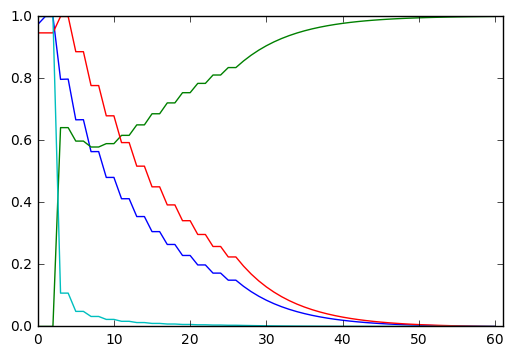

In [11]:
plt.plot(stdv(ans[6][0][:ans[5]]))
plt.plot(stdv(ans[6][1][:ans[5],0]))
plt.plot(stdv(ans[6][1][:ans[5],1]))
plt.plot(stdv(ans[6][1][:ans[5],2]))

plt.xlim(0,ans[5])
plt.show()

In [12]:
%timeit ans=ELLflash_explicit(Z,beta0,k0,MODEL,False)

100 loops, best of 3: 8.42 ms per loop


# using inear algebra

In [13]:
def ELLflash(Z,beta0,K0,MODEL): #ELLflash_linalg
    
    beta=beta0.copy()
    K=K0.copy()
    
    converged = 0
    
    looped2 = 0
    looped3 = 0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        prevK = K.copy()        
        
        looping3 = 0
        while ( (looping3 == 0)
               or (ResBeta>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)

            if beta[0,0]<0:
                beta[0,0]=0
                
            if 1<beta[0,0]:
                beta[0,0]=1
            
            ResBeta = beta[0,0]-prevbeta[0,0]

            looping3 += 1
            
        looped3 += looping3

        XI = (1./(1+beta * (K-1))) * Z

        gamaI = MODEL(XI/np.sum(XI))
        
        XII = K*XI

        gamaII = MODEL(XII/np.sum(XII))
        
        K = (gamaI)/(gamaII)
        
        ResK = np.linalg.norm(K-prevK)
        
        looping2 += 1 
        
    looped2 += looping2

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100  and ( 0. <= beta[0,0] <= 1.)  ):
        converged = 1
    
    return XI, XII, beta, converged, looped2, looped3

# did linear algebra make a difference here?

In [14]:
# no linalg, close to solution
%timeit ELLflash_explicit(Z,beta0,k0,MODEL,False)
ans=ELLflash_explicit(Z,beta0,k0,MODEL,False)
print(ans[3],ans[2])

# no linalg, a little far from solution
%timeit ELLflash_explicit(Z,beta0*beta0,k0/Z,MODEL,False)
ans=ELLflash_explicit(Z,2*beta0,k0/Z,MODEL,False)
print(ans[3],ans[2])

# linalg, close to solution
%timeit ELLflash(Z,beta0,k0,MODEL)
ans=ELLflash(Z,beta0,k0,MODEL)
print(ans[3],ans[2])

# linalg, a little far from solution
%timeit ELLflash(Z,2*beta0,k0/Z,MODEL)
ans=ELLflash(Z,2*beta0,k0/Z,MODEL)
print(ans[3],ans[2])

#approximately half the time here

# close to solution, 1.6ms drops to 0.9
# a little far from solution, 6.4ms drops to 3,4

100 loops, best of 3: 8.37 ms per loop
1 [[ 0.14951341]]
100 loops, best of 3: 13.3 ms per loop
1 [[ 0.14951384]]
The slowest run took 206.04 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 4.15 ms per loop
1 [[ 0.14951426]]
100 loops, best of 3: 5.79 ms per loop
1 [[ 0.14951415]]


# objective methodology for providing 'good' initial guesses


presented by Abreu, C. R. A., 2010 - COBEQ
as 
"a mdified version of Ohanomah e Thompson (1984)"

In [15]:
#Estimativas Iniciais

def iguess(Z,MODEL):
    #print(Z)

    gama0 = MODEL(Z/np.sum(Z))
    
    Xlin = 1/(gama0.T @ Z) * (gama0*Z)

    gamalin = MODEL(Xlin/np.sum(Xlin))

    Klin = (1./gamalin) * gama0

    KlinMin = np.min(Klin)
    KlinMax = np.max(Klin)

    NT = (KlinMax - KlinMin)
    
    nI0 = (KlinMax - Klin) * Z

    nII0 = (Klin-KlinMin) * Z
    
    beta0 = np.array([[ 1/(KlinMax-KlinMin) * np.sum(nII0) ]])
    
    ###
    
    XI0 = 1/(np.sum(nI0)) * nI0

    gamaI0=MODEL(XI0/np.sum(XI0))

    XII0 = 1/(np.sum(nII0)) * nII0

    gamaII0=MODEL(XII0/np.sum(XII0))
    
    K0 = (gamaI0)/(gamaII0)
    
    #K0 = (XII0+1e-5)/(XI0+1e-5)
    
    #print(XI0, XII0, gamaI0, gamaII0, K0)
    
    return beta0, K0

# see the iteration log when using these initial guesses

In [16]:
#test


#exact ad-hoc NRTL solution
#Ztest = np.array([[ 0.10526316,  0.84210526,  0.05263158]]).T
#XItest = np.array([[ 0.02616646,  0.93009914,  0.0437344 ]]).T
#XIItest = np.array([[ 0.51520944,  0.38604626,  0.0987443 ]]).T
#BETAtest = np.array([[ 0.16173772]])

#appproximate
Ztest = np.array([[ 0.1,  0.85,  0.05]]).T
#XItest = np.array([[ 0.025,  0.93,  0.045 ]]).T
#XIItest = np.array([[ 0.5,  0.39,  0.11 ]]).T

igtest = iguess(Ztest,MODEL)

BETAtest = igtest[0]

Ktest=igtest[1]

beta0=BETAtest
k0=Ktest
Z=Ztest


MODEL = lambda x: Gamma(T,x,alpha,A)

ans=ELLflash_explicit(Z,beta0,k0,MODEL,True)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.1   0.85  0.05]]
with ig of k0 [[ 53.51704507   0.08210211   1.89504205]] beta0 [[ 0.10903288]]
solution is
xi [ 0.02558676  0.93241488  0.04199836]
xii [ 0.52333357  0.38114549  0.09552094]
beta [[ 0.14950019]]
converged? 1 -- 1 means yes


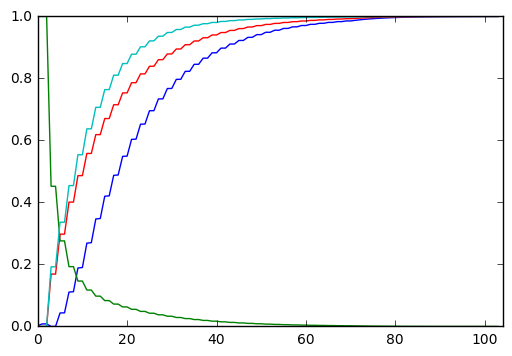

In [17]:
plt.plot(stdv(ans[6][0][:ans[5]]))
plt.plot(stdv(ans[6][1][:ans[5],0]))
plt.plot(stdv(ans[6][1][:ans[5],1]))
plt.plot(stdv(ans[6][1][:ans[5],2]))

plt.xlim(0,ans[5])
plt.show()

# grid calc plot

In [18]:
nspace = 90

Z2 = np.linspace(0,1,nspace)
Z3 = np.linspace(0,1,nspace)

Z2[0]=1e-9
Z3[0]=1e-9


Z2[-1]=1-1e-9
Z3[-1]=1-1e-9


rawZs = np.ndarray((nspace,nspace), dtype=object)

flags = np.zeros((nspace,nspace))

for i in range(nspace):
    for j in range(nspace):
        rawZs[i,j]=np.array([1-Z2[i]-Z3[j],Z2[i],Z3[j]])
        if ( Z2[i] + Z3[j] <= 1 ):
            flags[i,j] = 1
        

            
Zs = rawZs[np.where(flags==1)]

npts = Zs.shape[0]
print(npts)

Resultados_beta = np.zeros([npts])
Resultados_conv = np.zeros([npts])
Resultados_Z = np.zeros([npts,3])
Resultados_XI = np.zeros([npts,3])
Resultados_XII = np.zeros([npts,3])
Resultados_K0 = np.ndarray(npts, dtype = object)
Resultados_K = np.ndarray(npts, dtype = object)
Resultados_beta0 = np.zeros([npts])


sResultados_beta = np.zeros([npts])
sResultados_conv = np.zeros([npts])
sResultados_Z = np.zeros([npts,3])
sResultados_XI = np.zeros([npts,3])
sResultados_XII = np.zeros([npts,3])
sResultados_K0 = np.ndarray(npts, dtype = object)
sResultados_K = np.ndarray(npts, dtype = object)
sResultados_beta0 = np.zeros([npts])

MODEL = lambda x: Gamma(T,x,alpha,A)

l=0
ll=0
for k in range(npts):
    beta0, K0 = iguess(np.array([Zs[k]]).T,MODEL)
    #print(beta0,K0)
    #print(Zs[k],beta0,K0)
    ans = ELLflash(np.array([Zs[k]]).T,beta0,K0,MODEL)
    
    if (0<ans[2] and 1>ans[2] and ans[3]!=0):
        #print(ans[0][0][0],ans[0][1][0],ans[0][2][0])
        #print(ans[0][0:3,0])
        Resultados_XI[l,:] = ans[0][0:3,0]#np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
        Resultados_XII[l,:] = ans[1][0:3,0] #np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
        Resultados_beta[l] = ans[2]
        Resultados_conv[l] = ans[3]

        Resultados_Z[l,:] = Zs[k]
        
        Resultados_beta0[l] = beta0[0,0]
        Resultados_K0[l] = K0
        
        Resultados_K[l] = Resultados_XII[l,:]/Resultados_XI[l,:]
        
        l+=1
        #print('PASS', Zs[k], ans[0][0:3,0], ans[1][0:3,0], ans[2])
    else:
        #print('FAIL', k, Zs[k])
        pass
    
    if ( np.abs(Zs[k][1] - 5.16853933e-01) < 1e-4):
        
        sResultados_beta[ll] = ans[2]*ans[3] + (1-ans[3])* 0.310193764201
        sResultados_conv[ll] = ans[3]
        sResultados_Z[ll,:] = Zs[k]
        sResultados_beta0[ll] = beta0[0,0]
        sResultados_K0[ll] = K0
        sResultados_K[ll] = ans[1][0:3,0]/ans[0][0:3,0]*ans[3]+ np.asarray([ 0.03473608,  2.8461674 , 0.41370058])*(1-ans[3])
        ll+=1
        if ans[3] == 0:
            print( ans[3], #conv
               Zs[k],       
                    beta0, K0.T,

             )
        else:
            print( ans[3], #conv
               Zs[k],

            ans[0][0:3,0], #XI
            ans[1][0:3,0], #xII
            ans[2], #beta
            beta0, K0.T,
            ans[1][0:3,0]/ans[0][0:3,0]
          
                          
                  
         )  
print('done',l)
    
ndone=l-1

4095
1 [  4.83146066e-01   5.16853933e-01   1.00000000e-09] [  7.65294076e-01   2.34705923e-01   1.30185531e-09] [  1.43020513e-02   9.85697948e-01   4.98408452e-10] [[ 0.37570041]] [[ 0.51685393]] [[  1.02836137e-02   1.64901793e+01   4.94348060e-01]] [ 0.01868831  4.19971485  0.38284473]
1 [ 0.47191011  0.51685393  0.01123596] [ 0.72783522  0.2577572   0.01440758] [ 0.01553387  0.97888594  0.00558018] [[ 0.35929331]] [[ 0.52176019]] [[  1.17387635e-02   1.56605836e+01   5.04593055e-01]] [ 0.02134257  3.79770559  0.38730891]
1 [ 0.46067416  0.51685393  0.02247191] [ 0.6918431   0.27978761  0.02836928] [ 0.01683719  0.97201367  0.01114914] [[ 0.34246951]] [[ 0.52605261]] [[  1.30932463e-02   1.48063987e+01   5.10385276e-01]] [ 0.02433672  3.47411259  0.39300045]
1 [ 0.4494382   0.51685393  0.03370787] [ 0.65742939  0.30068123  0.04188939] [ 0.01822528  0.96502901  0.01674572] [[ 0.32539088]] [[ 0.52912249]] [[  0.01411511  13.88632034   0.50843824]] [ 0.02772203  3.20947544  0.39976038

* of a grid with 210 points we foundo solutions for 33 points
* lets soon see wether we tried calculations at conditions that do not have solution, or at conds that had solutions but our algorithms missed

In [19]:
fResultados_XI = Resultados_XI[:][np.where(Resultados_conv!=0)]
fResultados_XII = Resultados_XII[:][np.where(Resultados_conv!=0)]
fResultados_beta = Resultados_beta[np.where(Resultados_conv!=0)]
fResultados_Z = Resultados_Z[:][np.where(Resultados_conv!=0)]

In [20]:
# barycentric coords: (a,b,c)
a=fResultados_XI[:,0]
b=fResultados_XI[:,1]
c=fResultados_XI[:,2]

d=fResultados_XII[:,0]
e=fResultados_XII[:,1]
f=fResultados_XII[:,2]

g=fResultados_Z[:,0]
h=fResultados_Z[:,1]
ii=fResultados_Z[:,2]



In [21]:
# plot mole fractions results in axis of ethanol vc water

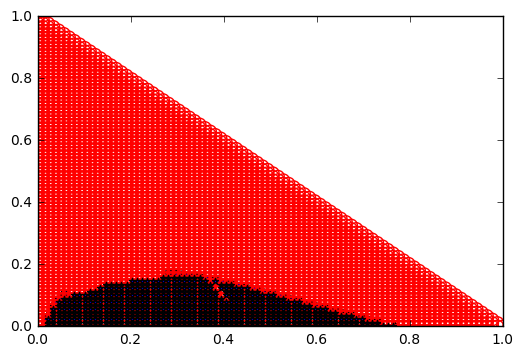

In [22]:
plt.axis([0,1,0,1])
    
plt.scatter(a,c)    
plt.scatter(d,f)    

ZS=np.zeros([npts,3])
for i in range(npts):
    ZS[i,:]=Zs[i]

plt.scatter(ZS[:,0],ZS[:,2],marker='o',s=80, facecolors='none', edgecolors='r')    
    
plt.scatter(g,ii,marker='*')

#UNCOMMENT THIS LINE TO PLOT THE FAILED POINT
#failedpoint= [0.42105263 , 0.52631579 , 0.05263158]
#plt.scatter(failedpoint[0],failedpoint[2],marker='d')

plt.show()

In [23]:
# x crit = 0.2 aprox


#refiltrar a e b LEFT and RIGHT of the crit point

crit=.2

al=a[np.where(a<=crit)]
ar=a[np.where(a>crit)]
dl=d[np.where(d<=crit)]
dr=d[np.where(d>crit)]

bl=b[np.where(a<=crit)]
br=b[np.where(a>crit)]
el=e[np.where(d<=crit)]
er=e[np.where(d>crit)]

cl=c[np.where(a<=crit)]
cr=c[np.where(a>crit)]
fl=f[np.where(d<=crit)]
fr=f[np.where(d>crit)]

In [24]:
Ly = np.concatenate((al,dl),axis=0)
Lx = np.concatenate((cl,fl),axis=0)

Ry = np.concatenate((ar,dr),axis=0)
Rx = np.concatenate((cr,fr),axis=0)

sLy=np.sort(Ly)
sLx=np.sort(Lx)
sRy=np.sort(Ry)
sRx=-np.sort(-Rx)

print(a.shape,b.shape,d.shape,e.shape)
print(al.shape,bl.shape,dl.shape,el.shape)
print(ar.shape,br.shape,dr.shape,er.shape)
print(Ly.shape,Ry.shape,Lx.shape,Rx.shape)


(642,) (642,) (642,) (642,)
(435,) (435,) (207,) (207,)
(207,) (207,) (435,) (435,)
(642,) (642,) (642,) (642,)


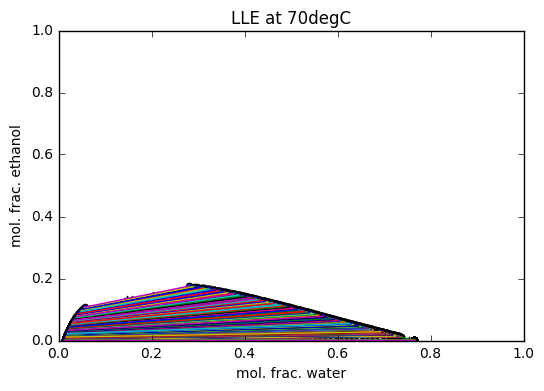

In [25]:
plt.axis([0,1,0,1])
    
plt.scatter(Ly,Lx)    
plt.scatter(Ry,Rx)    

plt.plot(sLy,sLx)
plt.plot(sRy,sRx)


for i in range(0,ndone):
    plt.plot([a[i],d[i]],[c[i],f[i]])


plt.scatter(g,ii, marker='*')

plt.xlabel('mol. frac. water')
plt.ylabel('mol. frac. ethanol')
plt.title('LLE at '+str(T-273)+'degC')    
    
plt.show()


# note that we tried flash at every open circle, but converged only at asteriscs
# outside the visible phase diagram, we sholud not have convergence because there is indeed no soltuiotn foe LLE
# however inside the phase envelope there is solution but our algorithm failed

[[ 1.]]
0 0 means did not cnverge


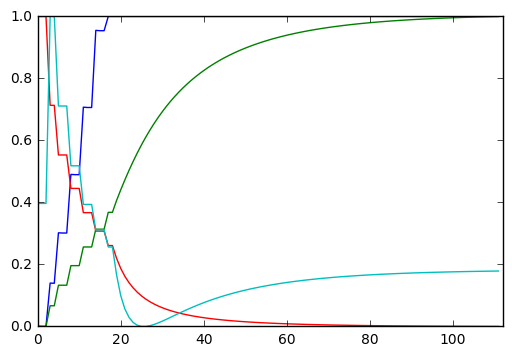

In [26]:


#what happended to some points:
failedpoint= [0.42105263 , 0.52631579 , 0.05263158]

ig = iguess(np.array([failedpoint]).T,MODEL)
#print('ig')
#print(ig)
ans=ELLflash_explicit(np.array([failedpoint]).T,ig[0],(ig[1]),MODEL,True)
#print(ans)

#lets study those points in a different notebook!

print(ans[2])
print(ans[3],'0 means did not cnverge')

plt.plot(stdv(ans[6][0][:ans[5]]))
plt.plot(stdv(ans[6][1][:ans[5],0]))
plt.plot(stdv(ans[6][1][:ans[5],1]))
plt.plot(stdv(ans[6][1][:ans[5],2]))

plt.xlim(0,ans[5])
plt.show()

# divergence in BETA caused by not good enough initial guess fr K0
# see below a trial with a different K0

[[ 0.79986453]] vs 0.310193764201
[[ 0.41875185  4.62153782  1.02404211]] vs [ 0.03473608  2.8461674   0.41370058]
[[ 0.31019376]]
1 1 means cnverge


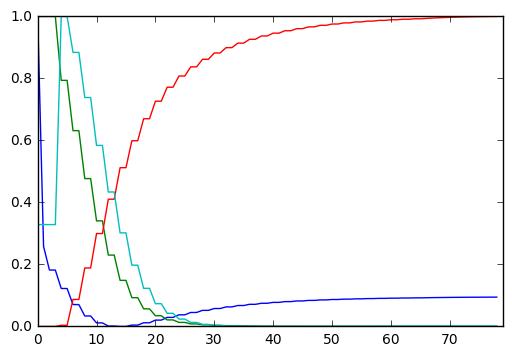

In [27]:
#what happended to some points:
failedpoint= [0.42105263 , 0.52631579 , 0.05263158]

ig = iguess(np.array([failedpoint]).T,MODEL)
#print('ig')
#print(ig)
ans=ELLflash_explicit(np.array([failedpoint]).T,ig[0],(ig[1])/2,MODEL,True)
#print('ans')
#print(ans)

#print(ans[1])

print(ig[0],'vs',ans[2][0,0])
print(ig[1].T,'vs',(ans[1][:]/ans[0][:]))


print(ans[2])
print(ans[3],'1 means cnverge')

#lets study those points in a different notebook!

plt.plot(stdv(ans[6][0][:ans[5]]))
plt.plot(stdv(ans[6][1][:ans[5],0]))
plt.plot(stdv(ans[6][1][:ans[5],1]))
plt.plot(stdv(ans[6][1][:ans[5],2]))

plt.xlim(0,ans[5])
plt.show()

# ig history

In [28]:
testZ2 = 0.52631579

npts=100

Zs = np.ndarray(npts, dtype=object)

i=0
for testZ1 in np.linspace(0,testZ2,npts):
    testZ3 = 1-testZ1-testZ2
    Zs[i] = np.asarray([testZ1,testZ2,testZ3])
    i+=1
    
    

In [29]:
Resultados_beta = np.zeros([npts])
Resultados_conv = np.zeros([npts])
Resultados_Z = np.zeros([npts,3])
Resultados_XI = np.zeros([npts,3])
Resultados_XII = np.zeros([npts,3])
Resultados_K0 = np.ndarray(npts, dtype = object)
Resultados_K = np.ndarray(npts, dtype = object)
Resultados_beta0 = np.zeros([npts])

sResultados_beta = np.zeros([npts])
sResultados_conv = np.zeros([npts])
sResultados_Z = np.zeros([npts,3])
sResultados_XI = np.zeros([npts,3])
sResultados_XII = np.zeros([npts,3])
sResultados_K0 = np.ndarray(npts, dtype = object)
sResultados_K = np.ndarray(npts, dtype = object)
sResultados_beta0 = np.zeros([npts])

MODEL = lambda x: Gamma(T,x,alpha,A)

l=0
ll=0
for k in range(npts):
    beta0, K0 = iguess(np.array([Zs[k]]).T,MODEL)
    #print(beta0,K0)
    #print(Zs[k],beta0,K0)
    ans = ELLflash(np.array([Zs[k]]).T,beta0,K0,MODEL)
    
    if (0<ans[2] and 1>ans[2] and ans[3]!=0):
        #print(ans[0][0][0],ans[0][1][0],ans[0][2][0])
        #print(ans[0][0:3,0])
        Resultados_XI[l,:] = ans[0][0:3,0]#np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
        Resultados_XII[l,:] = ans[1][0:3,0] #np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
        Resultados_beta[l] = ans[2]
        Resultados_conv[l] = ans[3]

        Resultados_Z[l,:] = Zs[k]
        
        Resultados_beta0[l] = beta0[0,0]
        Resultados_K0[l] = K0
        
        Resultados_K[l] = Resultados_XII[l,:]/Resultados_XI[l,:]
        
        l+=1
        #print('PASS', Zs[k], ans[0][0:3,0], ans[1][0:3,0], ans[2])
    else:
        #print('FAIL', k, Zs[k])
        pass
    

    
    sResultados_conv[ll] = ans[3]
    sResultados_Z[ll,:] = Zs[k]
    sResultados_beta0[ll] = beta0[0,0]
    sResultados_K0[ll] = K0
    
    if ans[3]==1:
        sResultados_beta[ll] = ans[2]
        sResultados_K[ll] = ans[1][0:3,0]/ans[0][0:3,0]
    else:
        sResultados_beta[ll] = ans[2]*0
        sResultados_K[ll] = ans[1][0:3,0]/ans[0][0:3,0]*0
    
    ll+=1
 
print('done',l)
    
ndone=l-1

/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in true_divide


done 40


[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          1.
  1.          1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.9473989   0.92386607  0.90278913
  0.88372061  0.86632151  0.85031202  0.83547414  0.82162759  0.80857401
  0.79616533  0.78472324  0.77401123  0.76361938  0.75360881  0.74397174
  0.73462545  0.72556555  

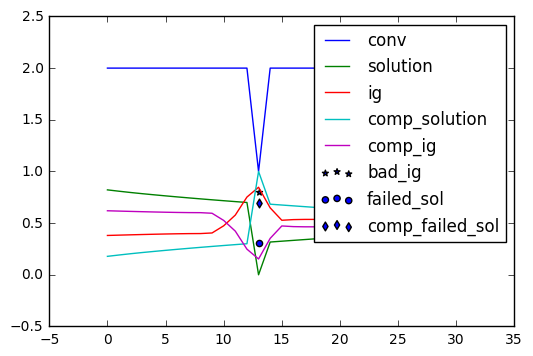

In [55]:
iterable = (sResultados_conv[l] for l in range(66,ll))
axis = np.fromiter(iterable, np.float)
print(axis)

plt.plot((axis+1),label='conv')

iterable = (sResultados_beta[l] for l in range(0,ll))
axis = np.fromiter(iterable, np.float)
print(axis)

FIRST_CONV = 66

iterable = (sResultados_beta[l] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(axis,label='solution')

iterable = (sResultados_beta0[l] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(axis,label='ig')

'''[[ 0.79986453]] vs 0.310193764201
[[ 0.41875185  4.62153782  1.02404211]] vs [ 0.03473608  2.8461674   0.41370058]'''

plt.scatter([13],[0.79986453],marker='*',label='bad_ig')
plt.scatter([13],[0.310193764201 ],label='failed_sol')
plt.scatter([13],[1-0.310193764201 ],marker='d',label='comp_failed_sol')


iterable = (sResultados_beta[l] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(1-axis,label='comp_solution')
iterable = (sResultados_beta0[l] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(1-axis,label='comp_ig')

plt.legend()

plt.show()

# IG CLOSE TO SOLUTION '2'

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in true_divide


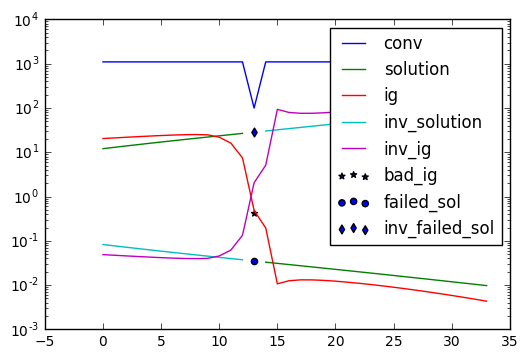

In [56]:
iterable = (sResultados_conv[l] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
print(axis)
plt.semilogy(1000*(axis)+100,label='conv')


iterable = (sResultados_K[l][0] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.semilogy(axis,label='solution')

iterable = (sResultados_K0[l][0] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.semilogy(axis,label='ig')

'''[[ 0.79986453]] vs 0.310193764201
[[ 0.41875185  4.62153782  1.02404211]] vs [ 0.03473608  2.8461674   0.41370058]'''

plt.scatter([13],[0.41875185],marker='*',label='bad_ig')
plt.scatter([13],[0.03473608],label='failed_sol')
plt.scatter([13],[1/0.03473608 ],marker='d',label='inv_failed_sol')


iterable = (sResultados_K[l][0] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(1/axis,label='inv_solution')
iterable = (sResultados_K0[l][0] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(1/axis,label='inv_ig')

plt.legend()

plt.show()

# ig right in the middle, closer to solution 1

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide


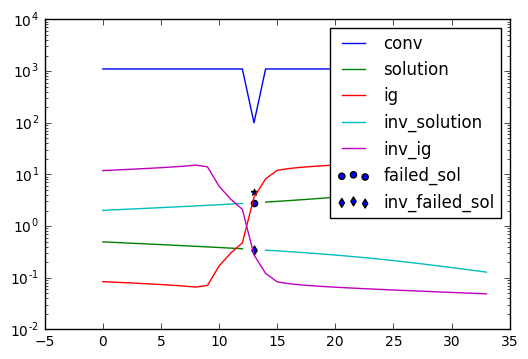

In [58]:
iterable = (sResultados_conv[l] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
print(axis)
plt.semilogy(1000*(axis)+100,label='conv')


iterable = (sResultados_K[l][1] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.semilogy(axis,label='solution')

iterable = (sResultados_K0[l][1] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.semilogy(axis,label='ig')

'''[[ 0.79986453]] vs 0.310193764201
[[ 0.41875185  4.62153782  1.02404211]] vs [ 0.03473608  2.8461674   0.41370058]'''

plt.scatter([13],[4.62153782],marker='*')
plt.scatter([13],[2.8461674 ],label='failed_sol')
plt.scatter([13],[1/2.8461674 ],marker='d',label='inv_failed_sol')

iterable = (sResultados_K[l][1] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(1/axis,label='inv_solution')
iterable = (sResultados_K0[l][1] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(1/axis,label='inv_ig')

plt.legend()

plt.show()

# ig CLOSE TO FEASIBLE SOLUTION '1'

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide


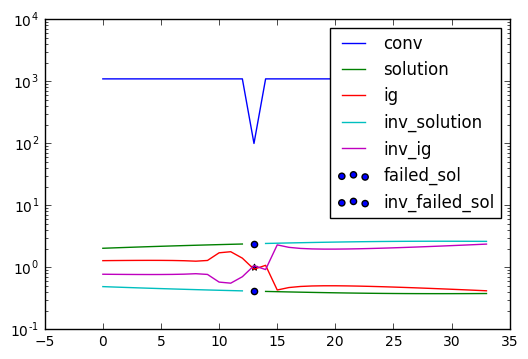

In [52]:
iterable = (sResultados_conv[l] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
print(axis)
plt.semilogy(1000*(axis)+100,label='conv')


iterable = (sResultados_K[l][2] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.semilogy(axis,label='solution')

iterable = (sResultados_K0[l][2] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.semilogy(axis,label='ig')

'''[[ 0.79986453]] vs 0.310193764201
[[ 0.41875185  4.62153782  1.02404211]] vs [ 0.03473608  2.8461674   0.41370058]'''

plt.scatter([13],[1.02404211],marker='*')
plt.scatter([13],[0.41370058 ],label='failed_sol')
plt.scatter([13],[1/0.41370058 ],label='inv_failed_sol')

iterable = (sResultados_K[l][2] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(1/axis,label='inv_solution')
iterable = (sResultados_K0[l][2] for l in range(FIRST_CONV,ll))
axis = np.fromiter(iterable, np.float)
plt.plot(1/axis,label='inv_ig')

plt.legend()

plt.show()

# INITIAL GUESS RIGHT IN THE MIDDEL OF TWO FEASIBLE SOLUTIONS